# Geospatial Analysis: Working with MODIS Raster data
<img src="https://misr.jpl.nasa.gov/files/mws/p49081_edited.jpg" width="800" height="400">

- [MCD19A1 v006 - MODIS/Terra+Aqua MAIAC Land Surface BRF Daily L2G Global 500 m and 1 km SIN Grid](https://lpdaac.usgs.gov/products/mcd19a1v006/)
- [MODIS MCD19A1 product user guide](https://lpdaac.usgs.gov/documents/110/MCD19_User_Guide_V6.pdf)
- [MODIS tile systems](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html)
- [MODIS general user guide](https://modis-land.gsfc.nasa.gov/pdf/MOD09_UserGuide_v1.4.pdf)
- [How to read MODIS data in python using pyhdf](https://moonbooks.org/Articles/How-to-read-a-MODIS-HDF-file-using-python-/)
- [Intro to MODIS and HDF data format using earthpy](https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/intro-to-hdf4/)
- [FTP site](https://e4ftl01.cr.usgs.gov/MOTA/MCD19A1.006/2020.09.02/)

In [1]:
import os
import re
import numpy as np
import numpy.ma as ma
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.plot as ep
import geopandas
import matplotlib.pyplot as plt
import requests
import dotenv
dotenv.load_dotenv(dotenv.find_dotenv())

True

***Download a MODIS tile***

In [2]:
tile = 'MCD19A1.A2020246.h08v05.006.2020270073445'
url = fr'https://e4ftl01.cr.usgs.gov/MOTA/MCD19A1.006/2020.09.02/{tile}.hdf'
login = os.getenv('user')
password = os.getenv('pwd')

In [3]:
r = requests.get(url, verify=True, stream=True,auth=(login,password))
open(f'{tile}.hdf',"wb").write(r.content)

132323589

***Load Data from MODIS HDF***

<img src="https://www.earthdatascience.org/images/earth-analytics/hierarchical-data-formats/hdf5-example-data-structure-with-metadata.jpg" width="400" height="400">

*HDF files are self describing - this means that all elements (the file itself, groups and datasets) can have associated metadata that describes the information contained within the element. Source: NEON*

In [14]:
all_bands = []

with rio.open(f'{tile}.hdf') as dataset:
    # capture meta and CRS data
    hdf4_meta = dataset.meta 
    crs = dataset.read_crs()
    
    # iterate data layers and select using name
    for layer_name in [name for name in dataset.subdatasets if 'grid500m:Sur_refl_500m' in name]:
        print(layer_name)
        with rio.open(layer_name) as subdataset:
            modis_meta = subdataset.profile
            all_bands.append(subdataset.read(1))

C:\Users\Ben\.conda\envs\gis\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


HDF4_EOS:EOS_GRID:MCD19A1.A2020246.h08v05.006.2020270073445.hdf:grid500m:Sur_refl_500m1
HDF4_EOS:EOS_GRID:MCD19A1.A2020246.h08v05.006.2020270073445.hdf:grid500m:Sur_refl_500m2
HDF4_EOS:EOS_GRID:MCD19A1.A2020246.h08v05.006.2020270073445.hdf:grid500m:Sur_refl_500m3
HDF4_EOS:EOS_GRID:MCD19A1.A2020246.h08v05.006.2020270073445.hdf:grid500m:Sur_refl_500m4
HDF4_EOS:EOS_GRID:MCD19A1.A2020246.h08v05.006.2020270073445.hdf:grid500m:Sur_refl_500m5
HDF4_EOS:EOS_GRID:MCD19A1.A2020246.h08v05.006.2020270073445.hdf:grid500m:Sur_refl_500m6
HDF4_EOS:EOS_GRID:MCD19A1.A2020246.h08v05.006.2020270073445.hdf:grid500m:Sur_refl_500m7


***Transform Spectral Bands 1-7***

In [15]:
# Stack pre-fire reflectance bands
pre_fire_modis = np.stack(all_bands)
print(f'Shape: {pre_fire_modis.shape}')
print(f'Meta: {modis_meta}')

Shape: (7, 2400, 2400)
Meta: {'driver': 'HDF4Image', 'dtype': 'int16', 'nodata': -28672.0, 'width': 2400, 'height': 2400, 'count': 4, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(463.31271652791725, 0.0, -11119505.196667,
       0.0, -463.3127165279167, 4447802.078667), 'tiled': False}


In [16]:
# Mask no data values
pre_fire_modis = ma.masked_where(pre_fire_modis == modis_meta["nodata"], pre_fire_modis)

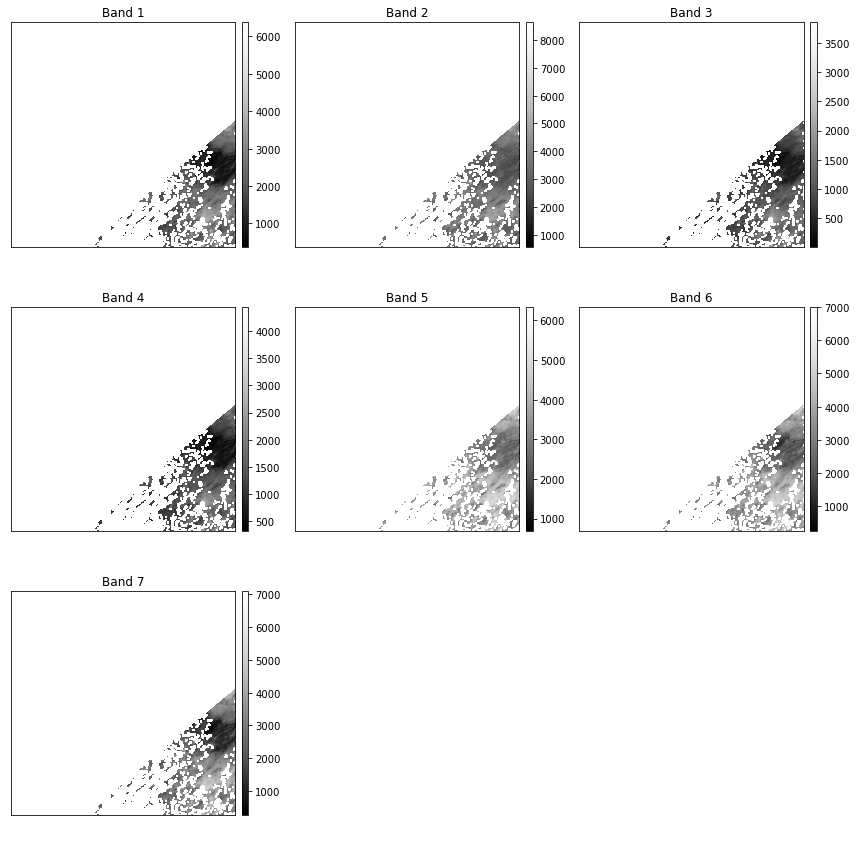

In [17]:
# plot
ep.plot_bands(pre_fire_modis,scale=False,cols=3)
plt.show()

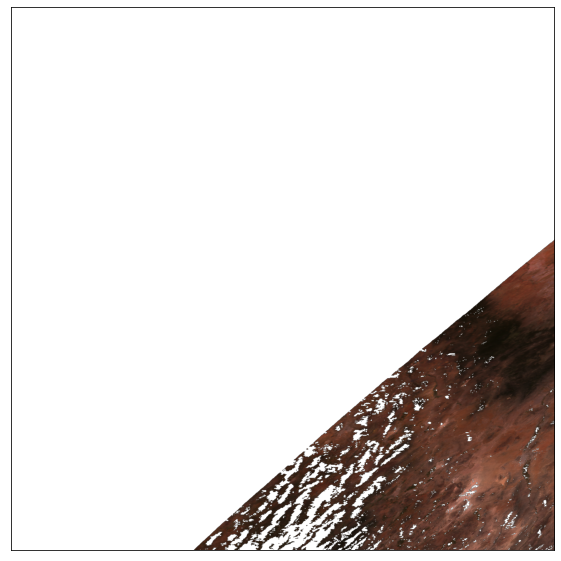

In [18]:
# plot Red, Green and Blue bands
ep.plot_rgb(pre_fire_modis,rgb=[0,3,2]) # RGB bands 1,4,3 (see user guide)
plt.show()

***Write to GeoTiff***

In [20]:
# prep metadata object
output_meta = modis_meta.copy()
output_meta['driver'] = 'GTiff'
output_meta['count'] = pre_fire_modis.shape[0]
output_meta

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -28672.0, 'width': 2400, 'height': 2400, 'count': 7, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(463.31271652791725, 0.0, -11119505.196667,
       0.0, -463.3127165279167, 4447802.078667), 'tiled': False}

In [21]:
out_path = f'{tile}.tif'
# Export file as a geotiff
with rio.open(out_path, "w", **output_meta) as dest:
    dest.write(pre_fire_modis)

***Load & Reproject GeoTiff***

Geopandas has a convinient global country dataset for plotting.

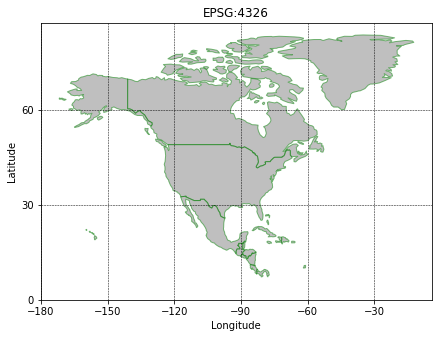

In [22]:
fig, ax = plt.subplots(figsize=(7,7))
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
NA = countries.loc[countries['continent']=='North America']
NA.plot(ax=ax, edgecolor='green',facecolor='grey',alpha=0.5)
ax.set_xticks(np.arange(-180,0,30))
ax.set_yticks(np.arange(0,90,30))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True,color='black',lw=0.5,linestyle='--')
ax.set_title(f"EPSG:{NA.crs.to_epsg()}");

However, in order to plot our MODIS Bands1-7 GeoTiff we will need to reproject the data from EPSG:9122 to the same CRS EPSG:4326 as GeoPandas. We can do this using [rasterio](https://rasterio.readthedocs.io/en/latest/topics/reproject.html) (see also[ this guide from Earth Lab at University of Colorado, Boulder)](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/reproject-raster/).

Altering CRS and reprojection is usefull for many geospatial analysis. The [OSGEO GDAL](https://gdal.org/) "*Geospatial Data Abstraction Library*" is another great tool for reprojection and QGIS provide a nice background on the topic [here](https://docs.qgis.org/3.10/en/docs/training_manual/vector_analysis/reproject_transform.html?highlight=reprojecting)

In [23]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [24]:
# Set desitnation CRS
# rio.crs.CRS.from_epsg(4326)
dst_crs = f"EPSG:{NA.crs.to_epsg()}"

# set out path
out_path_rproj = out_path.replace('.tif','-4326.tif')

with rio.open(out_path) as src:
    # get src bounds and transform
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
    # reproject and write to file
    with rio.open(out_path_rproj, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)

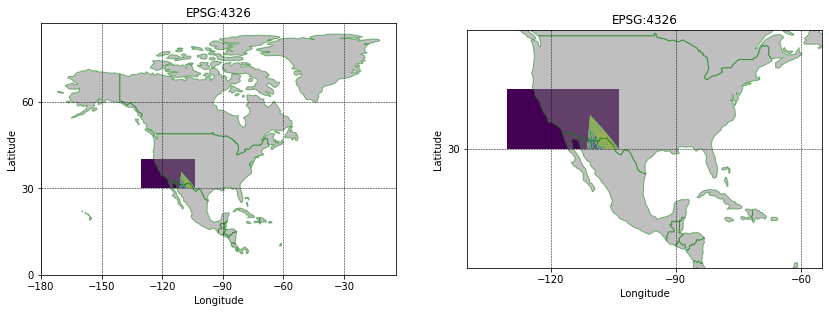

In [38]:
# plot the result
fig, axs = plt.subplots(1,2,figsize=(14,7))

raster = rio.open(out_path_rproj)
rio.plot.show((raster,1,4,3), ax=axs[0])
NA.plot(ax=axs[0], edgecolor='green',facecolor='grey',alpha=0.5)
axs[0].set_xticks(np.arange(-180,0,30))
axs[0].set_yticks(np.arange(0,90,30))
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].grid(True,color='black',lw=0.5,linestyle='--')
axs[0].set_title(f"EPSG:{NA.crs.to_epsg()}")

raster = rio.open(out_path_rproj)
rio.plot.show((raster,1,4,3), ax=axs[1])
NA.plot(ax=axs[1], edgecolor='green',facecolor='grey',alpha=0.5)
axs[1].set_xticks(np.arange(-180,0,30))
axs[1].set_yticks(np.arange(0,90,30))
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].grid(True,color='black',lw=0.5,linestyle='--')
axs[1].set_title(f"EPSG:{NA.crs.to_epsg()}")
axs[1].set_xlim(-140,-55)
axs[1].set_ylim(10,50);

***Leaflet***

In [26]:
from ipyleaflet import Map, basemaps, basemap_to_tiles,ImageOverlay
import matplotlib.pyplot as plt
%matplotlib inline

# !jupyter labextension install jupyter-leaflet
# !jupyter nbextension enable --py --sys-prefix ipyleaflet
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [36]:
m = Map(basemap=basemap_to_tiles(basemaps.NASAGIBS.ViirsEarthAtNight2012, "2017-04-08"),center=(30,-90),zoom=4)
image = ImageOverlay(url=out_path_rproj,bounds=((raster.bounds[1],raster.bounds[0]),(raster.bounds[3],raster.bounds[2])))
m.add_layer(image)
m

Map(center=[30, -90], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

### References
- [Official MODIS authentication Python and R scripts](https://lpdaac.usgs.gov/tools/data-prep-scripts/)